# Group: CopyPaste
#### Dataset used: Dataset_Hospital_Vists.csv, test.csv
#### Participants: Ligia, Gina, Raza

### Contents Draft

1. Problem and Goal Definition
2. Data Understanding
3. Data Quality Check
4. Exploratory Data Analysis
5. Data Cleaning and Preprocessing
6. Train-Test Split
7. Model Building
8. Model Evaluation
9. Model Interpretation
10. Fine-Tuning and Optimization

### 1. Problem and Goal Definition
Problem: Patients in a hospital miss their scheduled appointments.

Goal: Develop a machine learning model that predicts if a patient will miss a future appointment.

### 2. Data Understanding
#### 2.1 Dataset Description

- The dataset is at appointment level granularity and contains detail of each appointment and patient.

- It has 14 columns of which 1 will be our target variable: No-show.

- We mostly have information about an appointment's date and place and the patients' health details. A column also shows if a patient received an SMS before the appointment.

#### 2.2 Quick Analysis from Kaggle

- There is missing data in the columns Age, Community, Social Welfare, and some diseases.
- Female to Male ratio is 65:35.
- We have no NULLs in the target variable.
- For Handcap, we have multiple values even though it seems to be a binary variable.

### 3. Data Quality Check

- Uniqueness
- Missing data
- Data type consistency check
- Distribution of Categorical Variables
- Dates inconsistency

In [96]:
# Setting up environment with packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [97]:
# Importing the dataset

df = pd.read_csv("/Users/ligiavergara/Documents/GitHub/BIPM/Data Science/Project/Dataset_Hospital_Visits.csv")
df.head()

# Increase seaborn default resolution
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set(rc={'figure.figsize':(5,6)})

# Give variables to color numbers

green = '#008000'
red = '#ff0000'


In [98]:
## Uniqueness

# Is each row unique?

print("Duplicate rows: " + str(df.duplicated().sum()))

# Is each appointmentID unique?

print("Duplicate appointments: " + str(df['AppointmentID'].duplicated().sum()))

Duplicate rows: 0
Duplicate appointments: 0


We can conclude that the dataset only containts unique IDs and no duplicates.

In [5]:
## Missing Data

# Which columns have missing data?

missing_data = df.isnull().sum()
total_entries = len(df)
percentage_missing = round((missing_data / total_entries) * 100, 2)

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage Missing': percentage_missing
})

print(missing_info)

                 Missing Count  Percentage Missing
PatientId                    0                0.00
AppointmentID                0                0.00
Sex                          0                0.00
ScheduledDate                0                0.00
AppointmentDate              0                0.00
Age                       8807                9.96
Community                10713               12.12
SocialWelfare            12519               14.16
Hipertension              8021                9.07
Diabetes                     0                0.00
Alcoholism               14889               16.84
Handcap                      0                0.00
SMS_received                 0                0.00
No-show                      0                0.00


As seen from Kaggle, Age, Community, SocialWelfare, Hipertension, and Alcoholism have significant null values.

In [6]:
## Data Type Consistency

df.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
No-show             object
dtype: object

1. PatientId and Age are to be converted to int from float as IDs must be int/str and ages are usually considered in whole number terms.
2. ScheduledDate and AppointmentDate must be timestamps and not objects.

In [7]:
# Distribution of Categorical Variables

occ = df.groupby('Handcap').size().reset_index()
print(occ)

  Handcap      0
0       2    139
1       3     11
2       4      3
3      no  86626
4     yes   1642


We assume that this column was meant to be a binary column and the numerical values are bad data. They will be removed during data cleaning.

In [99]:
# Dates inconsistency

from datetime import datetime

df['AppointmentDate'] = df['AppointmentDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())
df['ScheduledDate'] = df['ScheduledDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())

counts = df['ScheduledDate'] > df['AppointmentDate']
occurrence_counts = counts.value_counts()

print(occurrence_counts)

False    88417
True         4
Name: count, dtype: int64


We see that we have 4 incoherent combination of schedule and appointment dates - they will be taken out in data cleaning stage.

### 4. Exploratory Data Analysis

- Distribution of the target variable.
- Distribution of age. Which age groups account for the most missing appointments?
- Do patients of a certain community miss their appointments more than others?
- Do males or females miss more appointments?

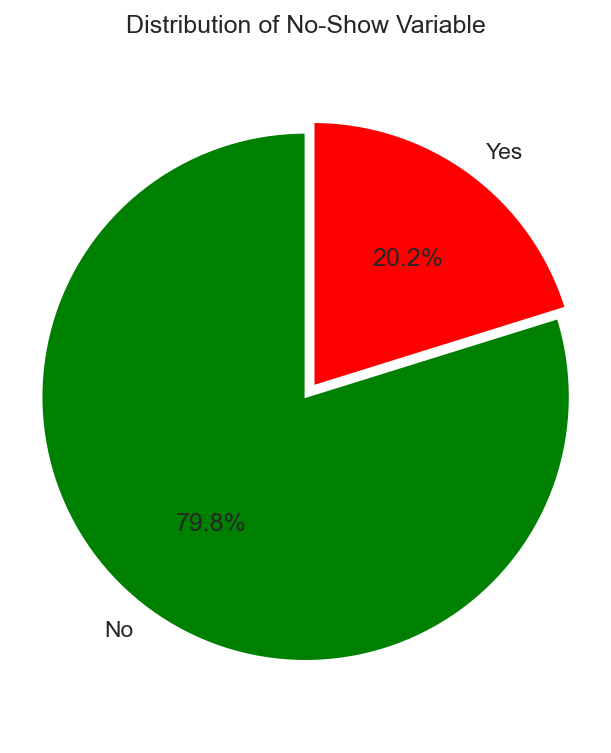

In [9]:
## Distribution of the target variable

value_counts = df['No-show'].value_counts()

labels = value_counts.index
sizes = value_counts.values

colors = [green,red]  # Customize colors
explode = (0.05, 0)  # Explode the 1st slice

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)

plt.title('Distribution of No-Show Variable')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

plt.show()

1 in 5 appointments are missed on average.

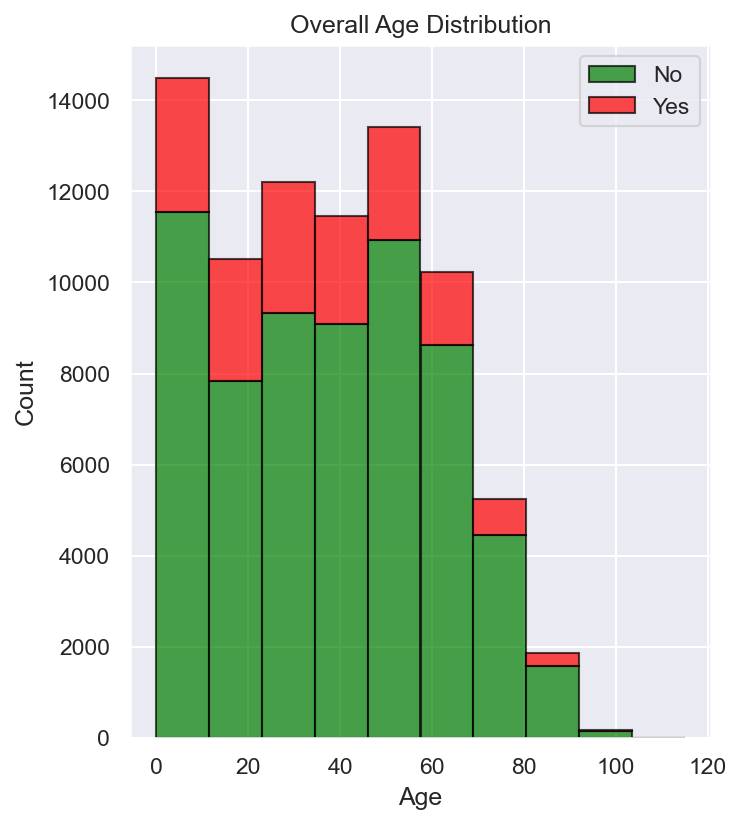

In [10]:
# Which age group misses more appointments?

# Plot histogram with split bars

plt.hist([df[df['No-show'] == 'No']['Age'], df[df['No-show'] == 'Yes']['Age']],
         bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

plt.title('Overall Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# To add % later:

# n, bins, _ = plt.hist([df[df['No-show'] == 'No']['Age'], df[df['No-show'] == 'Yes']['Age']],
#          bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

# for i in range(len(bins) - 1):
#     total = n[0][i] + n[1][i]
#     plt.text((bins[i] + bins[i + 1]) / 2, total, f'{n[0][i] / total:.0%}', ha='center', va='bottom')
#     plt.text((bins[i] + bins[i + 1]) / 2, total, f'{n[1][i] / total:.0%}', ha='center', va='top')

plt.show()

There is an even distribution of the ratio of appointments missed in the various age groups. This tends to change after age 70 where appointments are missed a lot less.

This could be explained by the fact that older people cannot afford to miss appointments due to more serious health issues and due to the fact that they might have more time on their hand.

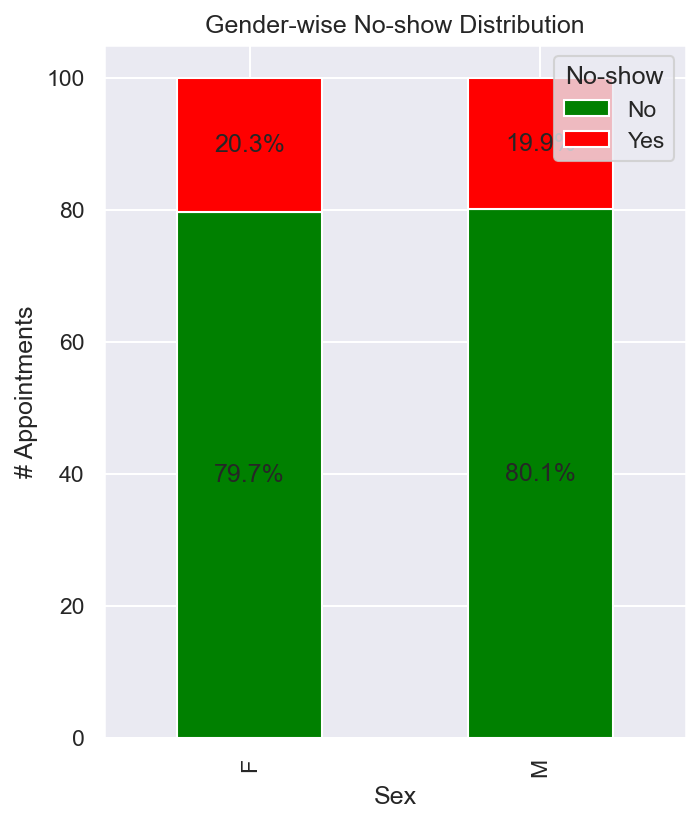

In [11]:
## Which gender misses more appointments?

# Group by 'gender' and 'no_show' and count occurrences
grouped_data = df.groupby(['Sex', 'No-show']).size().unstack()

# Calculate percentages
percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Plotting a grouped bar chart
ax = percentages.plot(kind='bar', stacked=True, color=[green, red])

# Annotate bars with percentages
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.title('Gender-wise No-show Distribution')
plt.xlabel('Sex')
plt.ylabel('# Appointments')
plt.legend(title='No-show', loc='upper right')

plt.show()

There seems to be 1 in 5 appointments missed for both genders.

/var/folders/1z/kkxxkq_90qldq3ngyx1pj0fr0000gn/T/ipykernel_1556/2128642182.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  appointments_per_community_show_up = sorted_df.groupby(['Community', 'No-show']).size().unstack(fill_value=0)


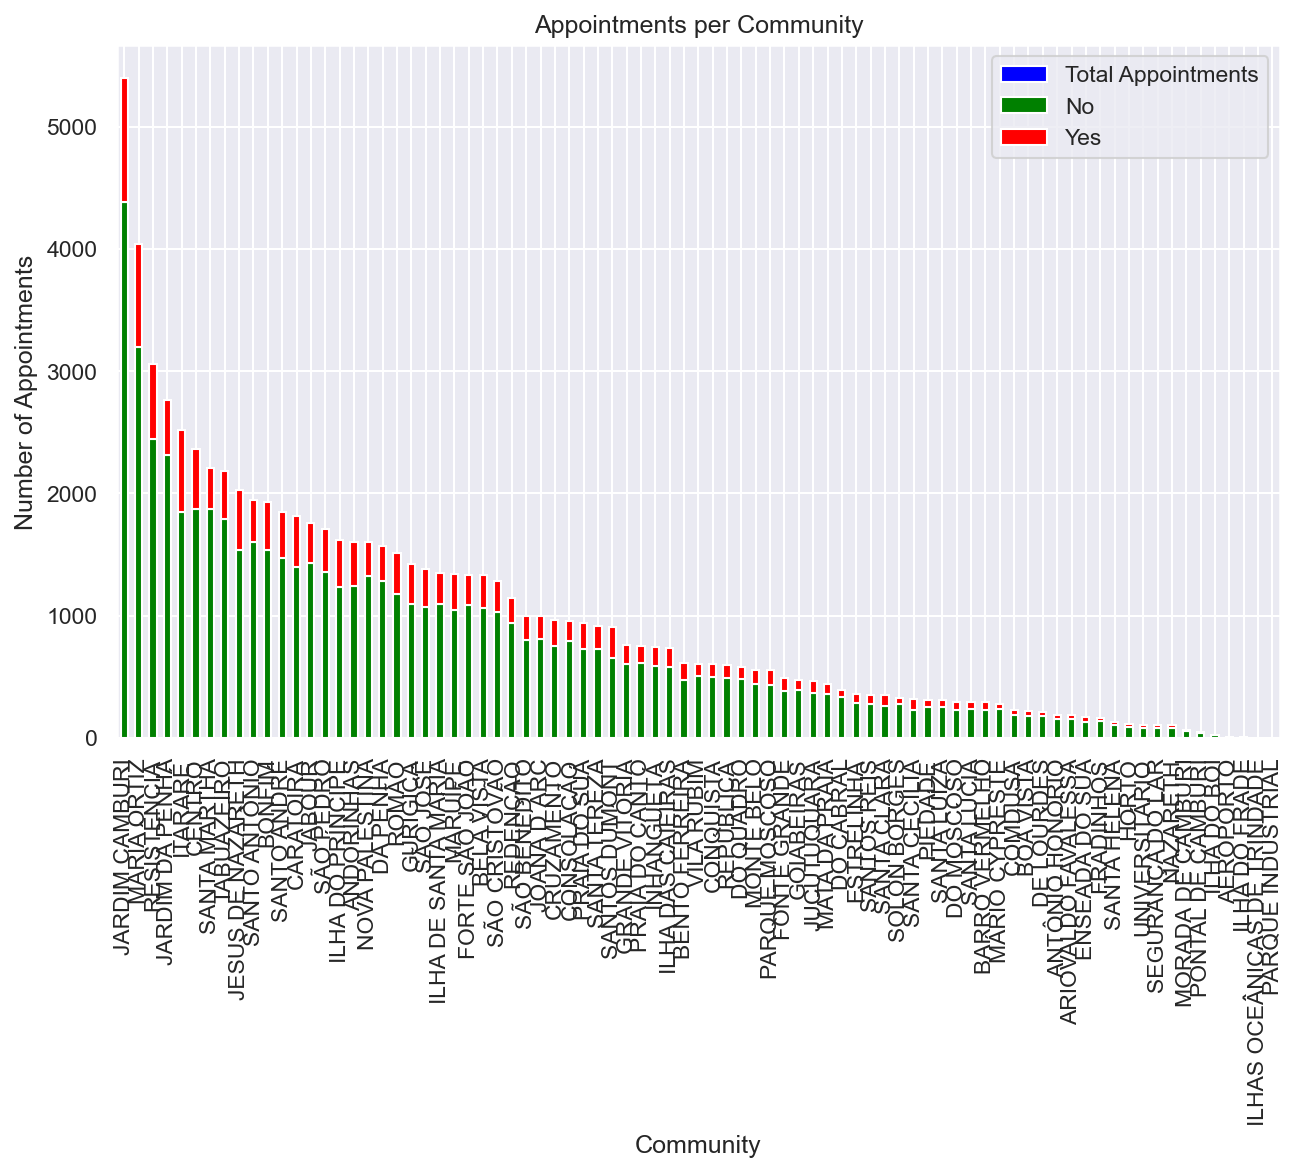

In [12]:

# Do patients of a certain community miss their appointments more than others?

# Count the total number of appointments per community
total_appointments_per_community = df['Community'].value_counts()

# Sort the DataFrame based on the total number of appointments
sorted_df = df[df['Community'].isin(total_appointments_per_community.index)].copy()
sorted_df['Community'] = pd.Categorical(sorted_df['Community'], categories=total_appointments_per_community.index, ordered=True)
sorted_df = sorted_df.sort_values(by=['Community'])

# Count the number of appointments per community split by show_up status
appointments_per_community_show_up = sorted_df.groupby(['Community', 'No-show']).size().unstack(fill_value=0)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart for total appointments per community
total_appointments_per_community.loc[sorted_df['Community'].unique()].plot(kind='bar', ax=ax, color='blue', label='Total Appointments')

# Bar chart for appointments per community split by show_up status
appointments_per_community_show_up.plot(kind='bar', stacked=True, ax=ax, color=['green', 'red'], label=['Show Up', 'No Show Up'])

# Adding labels and legend
ax.set_title('Appointments per Community')
ax.set_xlabel('Community')
ax.set_ylabel('Number of Appointments')
ax.legend()

plt.show()

### 5. Data Cleaning and Basic Preprocessing
- Dropping erroneous data
- Substituting illogical entries in Handicap column
- Extrapolating data for each patient where exists
- Time between ScheduledDate and AppointmentDate
- Standardization of Continuous variable

In [100]:
# Keeping original df intact

df_t = df[:]

In [14]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88421 entries, 0 to 88420
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        88421 non-null  float64
 1   AppointmentID    88421 non-null  int64  
 2   Sex              88421 non-null  object 
 3   ScheduledDate    88421 non-null  object 
 4   AppointmentDate  88421 non-null  object 
 5   Age              79614 non-null  float64
 6   Community        77708 non-null  object 
 7   SocialWelfare    75902 non-null  object 
 8   Hipertension     80400 non-null  object 
 9   Diabetes         88421 non-null  object 
 10  Alcoholism       73532 non-null  object 
 11  Handcap          88421 non-null  object 
 12  SMS_received     88421 non-null  object 
 13  No-show          88421 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 9.4+ MB


In [15]:
## Data Type Consistency

df_t.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
No-show             object
dtype: object

In [101]:
# Dropping erroneous data

# Dropping inconsistent dates from transformed dataframe

df_t = df_t.drop(df[df['ScheduledDate'] > df['AppointmentDate']].index)

In [102]:
# Assuming that the number is the number of handicaps

df_t.loc[df_t['Handcap'].isin(['2','3','4']), 'Handcap'] = 'yes'
df_t.info()
occ = df_t.groupby('Handcap').size().reset_index()
print(occ)

<class 'pandas.core.frame.DataFrame'>
Index: 88417 entries, 0 to 88420
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        88417 non-null  float64
 1   AppointmentID    88417 non-null  int64  
 2   Sex              88417 non-null  object 
 3   ScheduledDate    88417 non-null  object 
 4   AppointmentDate  88417 non-null  object 
 5   Age              79611 non-null  float64
 6   Community        77704 non-null  object 
 7   SocialWelfare    75899 non-null  object 
 8   Hipertension     80396 non-null  object 
 9   Diabetes         88417 non-null  object 
 10  Alcoholism       73529 non-null  object 
 11  Handcap          88417 non-null  object 
 12  SMS_received     88417 non-null  object 
 13  No-show          88417 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 10.1+ MB
  Handcap      0
0      no  86623
1     yes   1794


In [103]:
# Extrapolating missing data

missing_columns = ['Age', 'Community', 'SocialWelfare', 'Hipertension', 'Alcoholism']

for column in missing_columns:
    df_t[column] = df_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

/var/folders/bv/wljp2_jn7gzcm0jjwnmshvnm0000gn/T/ipykernel_5808/699699711.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_t[column] = df_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [104]:

# Adding New Feature: Time between ScheduledDate and AppointmentDate

from datetime import timedelta

df_t['time_bw_schedule_appointment'] = df_t['AppointmentDate'] - df_t['ScheduledDate']

## Convert to float (days)

df_t['time_bw_schedule_appointment'] = df_t['time_bw_schedule_appointment'] / pd.Timedelta(days=1)
df_t['time_bw_schedule_appointment'] = df_t['time_bw_schedule_appointment'].astype(float)

In [105]:
# Capitalising yes/no so they can be converted to binary column

df_t = df_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)
missing_data = df_t.isnull().sum()
total_entries = len(df_t)
percentage_missing = round((missing_data / total_entries) * 100, 2)

/var/folders/bv/wljp2_jn7gzcm0jjwnmshvnm0000gn/T/ipykernel_5808/17146736.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_t = df_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)


In [106]:
# Missing Data

missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage Missing': percentage_missing
})

print(missing_info)

                              Missing Count  Percentage Missing
PatientId                                 0                0.00
AppointmentID                             0                0.00
Sex                                       0                0.00
ScheduledDate                             0                0.00
AppointmentDate                           0                0.00
Age                                    3778                4.27
Community                              4631                5.24
SocialWelfare                          5450                6.16
Hipertension                           3406                3.85
Diabetes                                  0                0.00
Alcoholism                             6611                7.48
Handcap                                   0                0.00
SMS_received                              0                0.00
No-show                                   0                0.00
time_bw_schedule_appointment            

### 6. Train-Test Split

In [329]:
from sklearn.model_selection import train_test_split

# Avoiding Target Leakage by ensuring each patient is only in one dataset.

unique_patient_ids = df_t['PatientId'].unique()

# Splitting into test and train set.
patients_train, patients_test = train_test_split(unique_patient_ids, test_size=0.3, random_state=42)

# Removing some columns because do not need them anymore: both date columns as we have the difference now.

columns_to_drop = ["PatientId", "No-show", "AppointmentID", "ScheduledDate", "AppointmentDate"]

X_train = df_t[df_t['PatientId'].isin(patients_train)].drop(columns_to_drop, axis=1)
y_train = df_t[df_t['PatientId'].isin(patients_train)]["No-show"]

X_test = df_t[df_t['PatientId'].isin(patients_test)].drop(columns_to_drop, axis=1)
y_test = df_t[df_t['PatientId'].isin(patients_test)]["No-show"]

In [330]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 61652 entries, 0 to 88419
Series name: No-show
Non-Null Count  Dtype 
--------------  ----- 
61652 non-null  object
dtypes: object(1)
memory usage: 963.3+ KB


In [331]:
## Checking Target variable in both groups
train_counts = y_train.value_counts(normalize=True) * 100
train_counts

No-show
No     79.827094
Yes    20.172906
Name: proportion, dtype: float64

In [332]:
## Checking Target variable in both groups
test_counts = y_test.value_counts(normalize=True) * 100
test_counts

No-show
No     79.77209
Yes    20.22791
Name: proportion, dtype: float64

In [288]:
X_train.head()

,Sex,Age,Community,SocialWelfare,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,time_bw_schedule_appointment
0,F,24.0,Resistência,No,No,No,No,No,No,79.0
1,M,4.0,Tabuazeiro,No,No,No,No,No,No,9.0
2,F,19.0,Jardim da penha,No,No,No,No,No,No,0.0
3,F,55.0,Jesus de nazareth,No,Yes,No,No,No,No,0.0
5,F,51.0,Maruípe,No,Yes,No,No,No,Yes,13.0


### 7. Advanced Data Preprocessing
- Handling remaining missing Data: Imputation
- OneHotEncoding for Categorical Vairables
- Feature Selection based on Correlation Matrix
- Feature Selection based on Information Gain
- Feature Selection based on Automated Methods i.e. SelectKBest()

In [289]:
# Dealing with missing values via imputation

from sklearn.impute import SimpleImputer

median_imp = SimpleImputer(strategy='median', add_indicator=False)
mode_imp = SimpleImputer(strategy='most_frequent', add_indicator=False)

In [333]:
# One Hot Encoding of Categorical Variables

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, drop='if_binary')

In [334]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Separate columns into numeric and categorical
numeric_features = ["Age", "time_bw_schedule_appointment"]
categorical_features = ['SocialWelfare', 'Sex', 'Alcoholism', 'Hipertension', "Community"]

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', median_imp)
])

categorical_transformer = Pipeline(steps=[
    
    ('imputer', mode_imp),
    ('onehot', ohe)
])

# Apply transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

transformed_train = preprocessor.fit_transform(X_train)

In [335]:
# Confirming we have no remaining missing values in X_train

columns_train = preprocessor.get_feature_names_out()
transformed_train = pd.DataFrame(transformed_train, columns=columns_train)
transformed_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61652 entries, 0 to 61651
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   numeric__Age                                        61652 non-null  float64
 1   numeric__time_bw_schedule_appointment               61652 non-null  float64
 2   categorical__SocialWelfare_Yes                      61652 non-null  float64
 3   categorical__Sex_M                                  61652 non-null  float64
 4   categorical__Alcoholism_Yes                         61652 non-null  float64
 5   categorical__Hipertension_Yes                       61652 non-null  float64
 6   categorical__Community_Aeroporto                    61652 non-null  float64
 7   categorical__Community_Andorinhas                   61652 non-null  float64
 8   categorical__Community_Antônio honório              61652 non-null  float64


In [336]:
# Confirming we have no remaining missing values in X_test

transformed_test = preprocessor.fit_transform(X_test)
columns_test = preprocessor.get_feature_names_out()
transformed_test = pd.DataFrame(transformed_test, columns= columns_test)
transformed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26765 entries, 0 to 26764
Data columns (total 84 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   numeric__Age                                26765 non-null  float64
 1   numeric__time_bw_schedule_appointment       26765 non-null  float64
 2   categorical__SocialWelfare_Yes              26765 non-null  float64
 3   categorical__Sex_M                          26765 non-null  float64
 4   categorical__Alcoholism_Yes                 26765 non-null  float64
 5   categorical__Hipertension_Yes               26765 non-null  float64
 6   categorical__Community_Aeroporto            26765 non-null  float64
 7   categorical__Community_Andorinhas           26765 non-null  float64
 8   categorical__Community_Antônio honório      26765 non-null  float64
 9   categorical__Community_Ariovaldo favalessa  26765 non-null  float64
 10  categorica

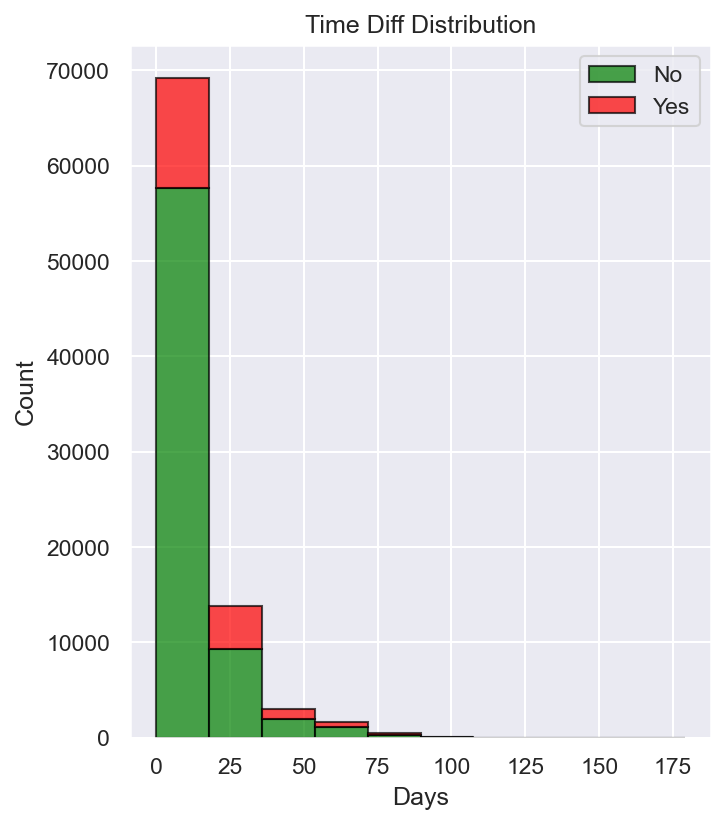

In [117]:
# Plot histogram with split bars ## EDA and can be removed later.

plt.hist([df_t[df_t['No-show'] == 'No']['time_bw_schedule_appointment'], df_t[df_t['No-show'] == 'Yes']['time_bw_schedule_appointment']],
         bins=10, color=['green', 'red'], alpha=0.7, edgecolor='black', label=['No', 'Yes'], stacked=True)

plt.title('Time Diff Distribution')
plt.xlabel('Days')
plt.ylabel('Count')
plt.legend()

plt.show()


### 7.2 Feature Selection

- Feature Selection based on Information Gain
- Feature Selection based on Automated Methods i.e. SelectKBest()

In [118]:
## Concatenating X_train and y_train for feature selection

transformed_train = transformed_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

df_feature_selection = pd.concat([transformed_train, y_train], axis = 1)

In [120]:
# Feature Selection: Correlation Matrix to understand which features have highest correlation with target variable and less correlation amongst each other.

df_t_encoded = pd.get_dummies(df_feature_selection, columns=['No-show'], drop_first=True).astype(int)

In [121]:
# Feature Selection based on Info Gain # FILTER ON > 0.003

from sklearn.feature_selection import mutual_info_classif

X = df_t_encoded.drop("No-show_Yes", axis=1)
y = df_t_encoded['No-show_Yes']

importances = mutual_info_classif(X, y)
feature_importances = pd.Series(importances, df_t_encoded.columns[0:len(df_t_encoded.columns)-1])
feature_importances.plot(kind="bar", color="teal")
plt.show()

KeyError: "['No-show_Yes'] not found in axis"

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, f_classif
from numpy import array

# Create training set and prediction target
X = df_t_encoded.drop("No-show_Yes", axis=1)
y = df_t_encoded['No-show_Yes']

# Perform feature selection
# Set k to the number of features you want to identify
select = SelectKBest(score_func=f_classif, k=4)
select.fit_transform(X,y)

# Print feature names
filter = select.get_support() 
features = array(X.columns)
 
print("Selected best:")
print(features[filter])

Selected best:
['numeric__Age' 'numeric__time_bw_schedule_appointment'
 'categorical__Hipertension_Yes' 'categorical__SMS_received_Yes']


### 8. Model Building


#### 8.1 Decision Tree

Turns out this brings the score down so we took it out of the soft voting classifier.

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier()

# Create pipeline
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', clf)]
)

In [161]:
pipe_dt

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Sex',
                                                   'Alcoholism', 'Hipertension',
                                                   'Community'])])),
                ('classifier', DecisionTreeClassifier())])

In [162]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Sex',
                                                   'Alcoholism', 'Hipertension',
                                                   'Community'])])),
                ('classifier', DecisionTreeClassifier())])

In [125]:
y_pred = pipe_dt.predict(X_test)

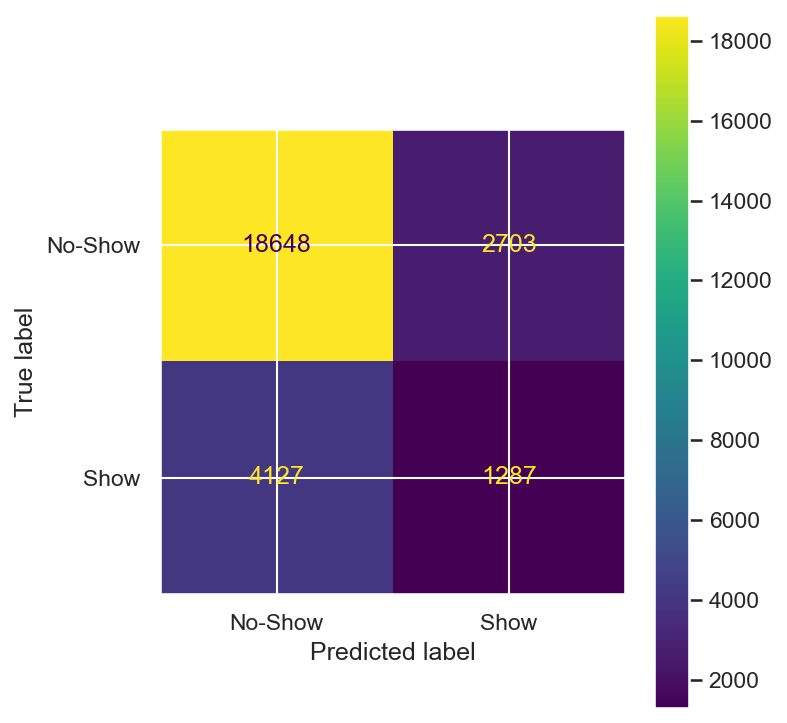

In [128]:
# Evaluating the model

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

display_labels=['No-Show', 'Show']
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=display_labels)
disp.plot()
plt.show()

In [129]:
# Print a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85     21351
           1       0.32      0.24      0.27      5414

    accuracy                           0.74     26765
   macro avg       0.57      0.56      0.56     26765
weighted avg       0.72      0.74      0.73     26765



#### 8.2 XGBOOST

In [294]:
# Encoding y train and y test to binary

mapping = {'No': 0, 'Yes': 1}
y_train = y_train.replace(mapping)
y_test = y_test.replace(mapping)

In [295]:
from xgboost import XGBClassifier

# Giving more weight to the minority class

num_positive_instances = np.sum(y_train == 1)
num_negative_instances = np.sum(y_train == 0)

imbalance_ratio = num_negative_instances / num_positive_instances

xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight = imbalance_ratio, subsample = 1.0 , n_estimators = 100, max_depth = 10, learning_rate = 0.1, gamma = 1, colsample_bytree = 0.8 )

pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb)]
)

pipe_xgb.fit(X_train, y_train)

preds_xgb = pipe_xgb.predict(X_test)

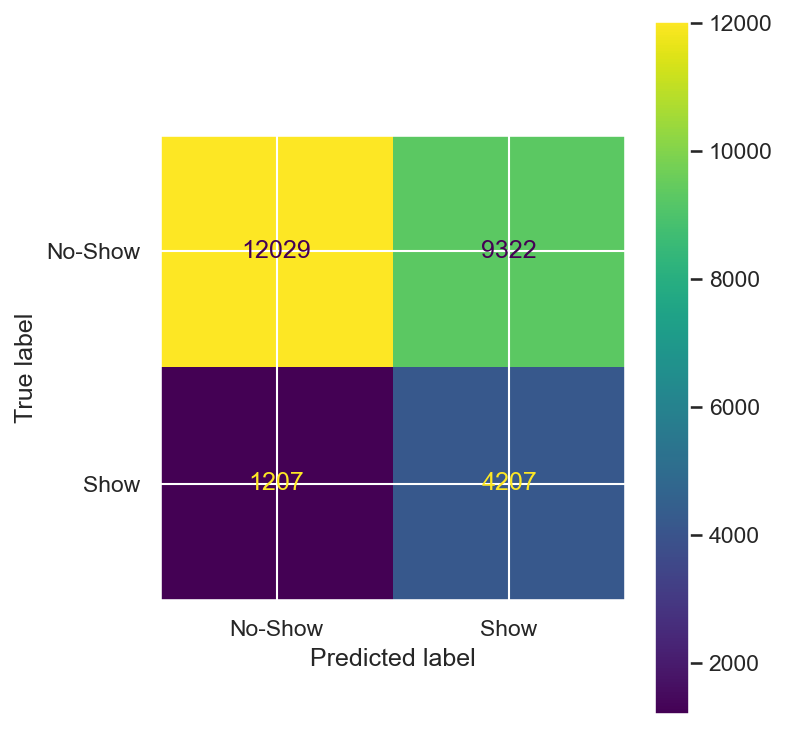

In [265]:
display_labels=['No-Show', 'Show']
cm = confusion_matrix(y_test, preds_xgb, labels=pipe_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=display_labels)
disp.plot()
plt.show()

In [123]:
## part of xg boost

from sklearn.metrics import classification_report
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.90      0.57      0.70     21351
           1       0.31      0.76      0.44      5414

    accuracy                           0.61     26765
   macro avg       0.61      0.67      0.57     26765
weighted avg       0.78      0.61      0.65     26765



##### 8.2.1 Random Search

In [180]:
# Optimizing HyperParameters

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [2, 4, 6, 8]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=10, scoring='f1', cv=5, random_state=42)

# Fit the RandomizedSearchCV object on th
random_search.fit(transformed_train, y_train)

# Retrieve the best model and hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(transformed_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Best Model Accuracy on Test Set: {accuracy:.4f}")
print("Best Hyperparameters:", best_params)
print(f"Best Model F1 on Test Set: {f1:.4f}")
print("Best Hyperparameters:", best_params)
print(f"Best Model Recall on Test Set: {recall:.4f}")
print("Best Hyperparameters:", best_params)

Best Model Accuracy on Test Set: 0.5889
Best Hyperparameters: {'subsample': 0.9, 'scale_pos_weight': 4, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Best Model F1 on Test Set: 0.4462
Best Hyperparameters: {'subsample': 0.9, 'scale_pos_weight': 4, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Best Model Recall on Test Set: 0.8188
Best Hyperparameters: {'subsample': 0.9, 'scale_pos_weight': 4, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}


##### 8.2.2. Halving Grid Search

In [188]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.datasets import make_classification


# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [2, 4, 6, 8]

}

# Create a HalvingGridSearchCV object (Hyperband with grid search)
hyperband_search = HalvingRandomSearchCV(xgb, param_grid, factor=3, cv=3, random_state=42, scoring="f1",max_resources=20)

# Fit the Hyperband search on the training data
hyperband_search.fit(transformed_train, y_train)


best_rf_model = hyperband_search.best_estimator_
best_params = hyperband_search.best_params_

y_pred = best_rf_model.predict(transformed_test)

f1 = f1_score(y_test, y_pred)
print(f"Best Model F1 on Test Set: {f1:.4f}")
print("Best Hyperparameters:", best_params)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Best Model F1 on Test Set: 0.4362
Best Hyperparameters: {'subsample': 1.0, 'scale_pos_weight': 6, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8}


#### 8.3 RANDOM FOREST

In [296]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate rf
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=None, random_state=42, n_jobs=-1)

pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)]
)

pipe_rf.fit(X_train, y_train)

preds_rf = pipe_rf.predict(X_test)
preds_rf

array([0, 0, 0, ..., 0, 0, 0])

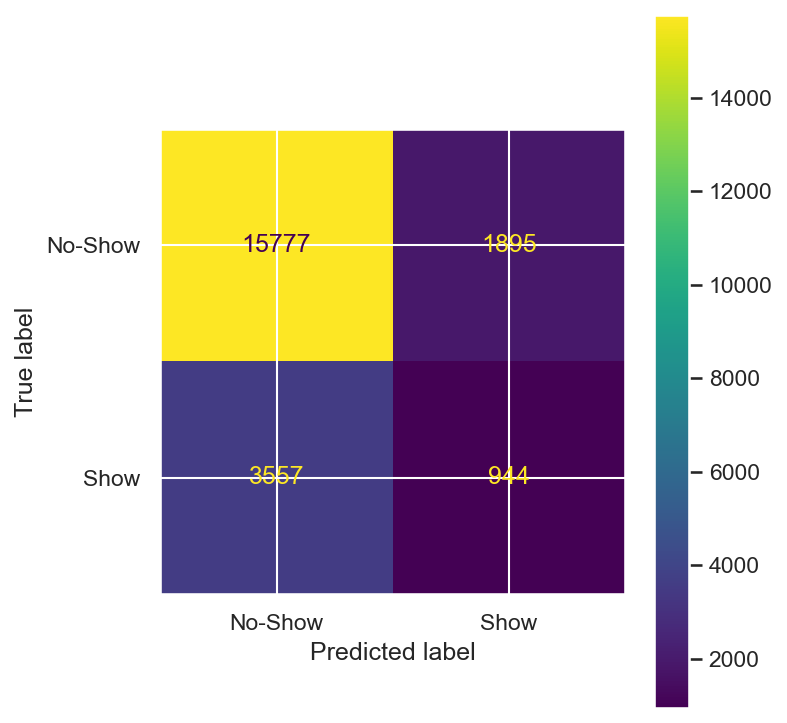

In [297]:
display_labels=['No-Show', 'Show']
cm = confusion_matrix(y_test, preds_rf, labels=pipe_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=display_labels)
disp.plot()
plt.show()

In [126]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds_rf))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     21351
           1       0.52      0.01      0.01      5414

    accuracy                           0.80     26765
   macro avg       0.66      0.50      0.45     26765
weighted avg       0.74      0.80      0.71     26765



##### 8.3.1 Random Search

In [338]:
transformed_train = transformed_train.drop(columns=['categorical__Community_Ilhas oceânicas de trindade', "categorical__Community_Parque industrial","categorical__Community_Ilha do frade" ])

In [176]:
# Optimizing HyperParameters

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=20, scoring='f1', cv=5, random_state=42)

# Fit the RandomizedSearchCV object on th
random_search.fit(transformed_train, y_train)

# Retrieve the best model and hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(transformed_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Best Model Accuracy on Test Set: {accuracy:.4f}")
print("Best Hyperparameters:", best_params)
print(f"Best Model F1 on Test Set: {f1:.4f}")
print("Best Hyperparameters:", best_params)
print(f"Best Model Recall on Test Set: {recall:.4f}")
print("Best Hyperparameters:", best_params)

Best Model Accuracy on Test Set: 0.7585
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best Model F1 on Test Set: 0.2553
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best Model Recall on Test Set: 0.2047
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


##### 8.3.2. Halving Grid Search

In [190]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.datasets import make_classification


# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']

}

# Create a HalvingGridSearchCV object (Hyperband with grid search)
hyperband_search = HalvingGridSearchCV(rf, param_grid, factor=3, cv=3, random_state=42, scoring="f1")

# Fit the Hyperband search on the training data
hyperband_search.fit(transformed_train, y_train)


best_rf_model = hyperband_search.best_estimator_
best_params = hyperband_search.best_params_

y_pred = best_rf_model.predict(transformed_test)

f1 = f1_score(y_test, y_pred)
print(f"Best Model F1 on Test Set: {f1:.4f}")
print("Best Hyperparameters:", best_params)

Best Model F1 on Test Set: 0.2594
Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


#### 8.4 Logistic Regression

In [307]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(class_weight = 'balanced', solver = 'liblinear', penalty = 'l2', fit_intercept = True, C = 0.001, dual=True)


pipe_lgr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgr)]
)

pipe_lgr.fit(X_train, y_train)

preds_lgr = pipe_lgr.predict(X_test)
preds_lgr

array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'No', 'No'], dtype=object)

##### 8.4.1 Random Search

In [193]:
# Optimizing HyperParameters

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

param_dist = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 4}] 
}
# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(lgr, param_distributions=param_dist, n_iter=30, scoring='f1', cv=5, random_state=42)

# Fit the RandomizedSearchCV object on th
random_search.fit(transformed_train, y_train)

# Retrieve the best model and hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(transformed_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Best Model Accuracy on Test Set: {accuracy:.4f}")
print("Best Hyperparameters:", best_params)
print(f"Best Model F1 on Test Set: {f1:.4f}")
print("Best Hyperparameters:", best_params)
print(f"Best Model Recall on Test Set: {recall:.4f}")
print("Best Hyperparameters:", best_params)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

Best Model Accuracy on Test Set: 0.6789
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'fit_intercept': True, 'class_weight': {0: 1, 1: 4}, 'C': 0.001}
Best Model F1 on Test Set: 0.4145
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'fit_intercept': True, 'class_weight': {0: 1, 1: 4}, 'C': 0.001}
Best Model Recall on Test Set: 0.5619
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'fit_intercept': True, 'class_weight': {0: 1, 1: 4}, 'C': 0.001}


##### 8.4.2 Halving Search

In [197]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.datasets import make_classification


# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['liblinear', 'saga'] 

}

# Create a HalvingGridSearchCV object (Hyperband with grid search)
hyperband_search = HalvingGridSearchCV(lgr, param_grid, factor=3, cv=3, random_state=42, scoring="f1",max_resources=20)

# Fit the Hyperband search on the training data
hyperband_search.fit(transformed_train, y_train)


best_rf_model = hyperband_search.best_estimator_
best_params = hyperband_search.best_params_

y_pred = best_rf_model.predict(transformed_test)

f1 = f1_score(y_test, y_pred)
print(f"Best Model F1 on Test Set: {f1:.4f}")
print("Best Hyperparameters:", best_params)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

Best Model F1 on Test Set: 0.4125
Best Hyperparameters: {'C': 0.001, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}


#### 8.5 Voting Classifier

In [323]:
from sklearn.ensemble import VotingClassifier

weights = [2, 2, 1]

svc = VotingClassifier(estimators=[('xgb', xgb), ('lgr', lgr), ('rf', rf)], voting='soft', weights=weights)
hvc = VotingClassifier(estimators=[('dt', clf), ('xgb', xgb), ('rf', rf)], voting='hard')

pipe_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svc)]
)

pipe_hvc = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', hvc)]
)

In [324]:
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age',
                                                   'time_bw_schedule_appointment']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['SocialWelfare', 'Sex',
                                                   '...
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...)),
                                              ('lgr',
                                               LogisticRegression(C=0.001,
                                                                  class_weight='balanced',
                                                                  dual=True,
                                                                  solver='liblinear')),
                                              ('rf',
                                               RandomForestClassifier(max_features='log2',
                                                                      n_jobs=-1,
                                                                      random_state=42))],
                                  voting='soft', weights=[2, 2, 1]))])

In [56]:
# # Evaluate the classifiers

# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score

# hard_voting_pred = pipe_hvc.predict(X_test)
# soft_voting_pred = pipe_svc.predict(X_test)

# print("F1 with Hard Voting:", f1_score(y_test, hard_voting_pred))
# print("F1 with Soft Voting:", f1_score(y_test, soft_voting_pred))
# print("Accuracy with Hard Voting:", precision_score(y_test, hard_voting_pred))
# print("Accuracy with Soft Voting:", precision_score(y_test, soft_voting_pred))
# print("Accuracy with Hard Voting:", recall_score(y_test, hard_voting_pred))
# print("Accuracy with Soft Voting:", recall_score(y_test, soft_voting_pred))

### 9. Model Evaluation

#### 9.1 Feature Permutation

In [249]:
from sklearn.metrics import accuracy_score

y_pred_original = pipe_svc.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)
print(f"Accuracy on original data: {accuracy_original:.4f}")

Accuracy on original data: 0.7004


In [250]:
from sklearn.inspection import permutation_importance

perm_result = permutation_importance(pipe_svc, X_test, y_test, n_repeats=30, random_state=42)

KeyboardInterrupt: 

In [111]:
print(perm_result)

{'importances_mean': array([ 0.00143595,  0.01835606,  0.01150508,  0.00111215,  0.00113955,
       -0.00082446,  0.00072109, -0.00060527, -0.00034871,  0.08270627]), 'importances_std': array([0.00083815, 0.00184997, 0.00135211, 0.00088382, 0.00072273,
       0.0003686 , 0.00033462, 0.00029927, 0.00092612, 0.00187151]), 'importances': array([[ 3.17578928e-03,  1.45712684e-03,  5.60433402e-04,
         2.50326919e-03,  1.34504016e-03,  6.72520082e-04,
         2.72744256e-03,  4.48346721e-04,  2.09228470e-03,
         1.08350458e-03,  1.19559126e-03,  8.96693443e-04,
         2.65271810e-03,  2.05492247e-03,  1.90547357e-03,
         1.00878012e-03,  1.64393798e-03,  3.73622268e-05,
         3.73622268e-05,  8.21968989e-04,  1.15822903e-03,
         1.68130021e-03,  9.34055670e-04,  1.30767794e-03,
         1.64393798e-03, -1.12086680e-04,  1.45712684e-03,
         2.65271810e-03,  1.56921353e-03,  2.46590697e-03],
       [ 2.07733981e-02,  1.90173734e-02,  1.64393798e-02,
         2.12

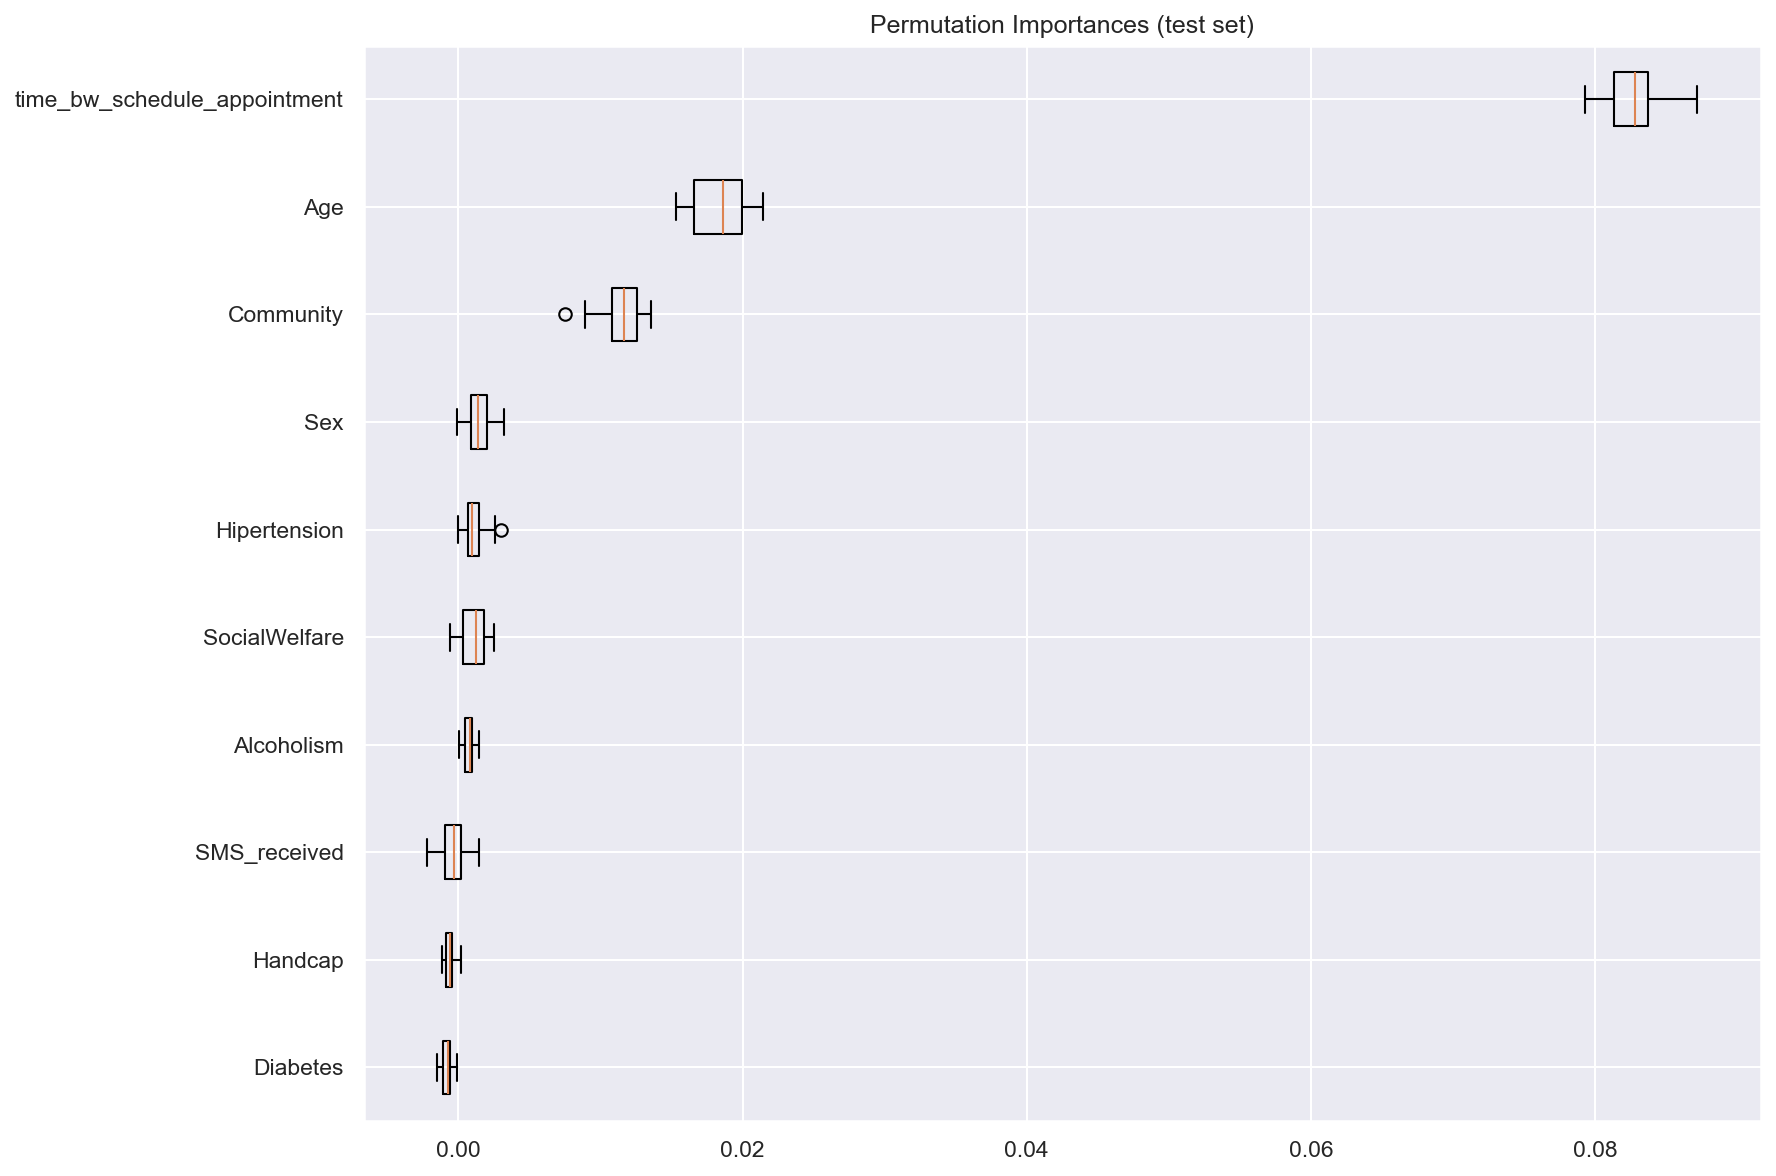

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Sorting the features by importance
sorted_idx = perm_result.importances_mean.argsort()

# Plotting
plt.figure(figsize=(12, 8))
plt.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=np.array(X_train.columns)[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

#### 9.2 Preprocessing test.cv

In [210]:
# Keeping original df_test intact:

df_test = pd.read_csv('/Users/ligiavergara/Documents/GitHub/BIPM/Data Science/Project/test.csv')

df_test_t = df_test[:]

In [211]:
df_test_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        22106 non-null  float64
 1   AppointmentID    22106 non-null  int64  
 2   Sex              22106 non-null  object 
 3   ScheduledDate    22106 non-null  object 
 4   AppointmentDate  22106 non-null  object 
 5   Age              19955 non-null  float64
 6   Community        19461 non-null  object 
 7   SocialWelfare    19043 non-null  object 
 8   Hipertension     20089 non-null  object 
 9   Diabetes         22106 non-null  object 
 10  Alcoholism       18371 non-null  object 
 11  Handcap          22106 non-null  object 
 12  SMS_received     22106 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.2+ MB


In [212]:
## Data Type Consistency

df_test_t.dtypes

PatientId          float64
AppointmentID        int64
Sex                 object
ScheduledDate       object
AppointmentDate     object
Age                float64
Community           object
SocialWelfare       object
Hipertension        object
Diabetes            object
Alcoholism          object
Handcap             object
SMS_received        object
dtype: object

In [213]:
from datetime import datetime

df_test_t['AppointmentDate'] = df_test_t['AppointmentDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())
df_test_t['ScheduledDate'] = df_test_t['ScheduledDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date())

In [214]:
# Dropping erroneous data

# Dropping inconsistent dates from transformed dataframe

# df_test_t = df_test_t.drop(df_test[df_test['ScheduledDate'] > df_test['AppointmentDate']].index)

In [215]:
# Dropping outliers for Handcap: 2, 3, 4

import numpy as np

df_test_t.loc[df_test_t['Handcap'].isin(['2', '3', '4']), 'Handcap'] = 'yes'
df_test_t.info()
occ_test = df_test_t.groupby('Handcap').size().reset_index()
print(occ_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22106 entries, 0 to 22105
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PatientId        22106 non-null  float64
 1   AppointmentID    22106 non-null  int64  
 2   Sex              22106 non-null  object 
 3   ScheduledDate    22106 non-null  object 
 4   AppointmentDate  22106 non-null  object 
 5   Age              19955 non-null  float64
 6   Community        19461 non-null  object 
 7   SocialWelfare    19043 non-null  object 
 8   Hipertension     20089 non-null  object 
 9   Diabetes         22106 non-null  object 
 10  Alcoholism       18371 non-null  object 
 11  Handcap          22106 non-null  object 
 12  SMS_received     22106 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.2+ MB
  Handcap      0
0      no  21660
1     yes    446


In [216]:
# Extrapolating missing data

missing_columns = ['Age', 'Community', 'SocialWelfare', 'Hipertension', 'Alcoholism']

for column in missing_columns:
    df_test_t[column] = df_test_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


/var/folders/bv/wljp2_jn7gzcm0jjwnmshvnm0000gn/T/ipykernel_5808/1740001506.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test_t[column] = df_test_t.groupby('PatientId')[column].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [217]:

# Adding New Feature: Time between ScheduledDate and AppointmentDate

df_test_t['time_bw_schedule_appointment'] = df_test_t['AppointmentDate'] - df_test_t['ScheduledDate']

## Convert to float (days)

df_test_t['time_bw_schedule_appointment'] = df_test_t['time_bw_schedule_appointment'] / pd.Timedelta(days=1)
df_test_t['time_bw_schedule_appointment'] = df_test_t['time_bw_schedule_appointment'].astype(float)

In [218]:
# Capitalising yes/no so they can be converted to binary column

df_test_t = df_test_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)

/var/folders/bv/wljp2_jn7gzcm0jjwnmshvnm0000gn/T/ipykernel_5808/470778378.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_test_t = df_test_t.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)


In [219]:
X_df_test = df_test_t.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDate', 'AppointmentDate'])

#### 9.2 Model Evaluation

In [318]:
y_pred_test = pipe_svc.predict(X_df_test)

In [319]:
df_test_t["No-show"] = y_pred_test

In [320]:
mapping = {0: 'No', 1: 'Yes'}
df_test_t["No-show"] = df_test_t["No-show"].replace(mapping)
Submission = df_test_t[["AppointmentID", "No-show"]]
Submission.head()

,AppointmentID,No-show
0,5620835,Yes
1,5741692,No
2,5673005,No
3,5579701,No
4,5652332,No


In [321]:
Submission = df_test_t[["AppointmentID", "No-show"]]
Submission.head()

,AppointmentID,No-show
0,5620835,Yes
1,5741692,No
2,5673005,No
3,5579701,No
4,5652332,No


In [322]:
filepath = '/Users/ligiavergara/Documents/GitHub/BIPM/Data Science/Project/tuning_SVC_W2_3_1.csv'
Submission.to_csv(filepath, index=False)

### 10. Model Interpretation


### 11. Fine-Tuning and Optimization